In [1]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

from sklearn.utils import shuffle
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV

import math
import numpy as np
import random
import logging
import numbers

In [2]:
random_state = 20
epsilon = 0.001
machine_list = ['RSF','DeepHit','MLTR','Cox_Time']   
n_patients = 312

In [3]:
# Import Predictions
import pickle
"""Dictionaries of the form {'patient_id':'Predictions_array'}"""
rsf_predictions = pickle.load( open( "patient_surv_functions/rsf.p", "rb" ) )
deep_hit_predictions = pickle.load( open( "patient_surv_functions/deep_hit.p", "rb" ) )
mltr_predictions = pickle.load( open( "patient_surv_functions/mltr.p", "rb" ) )
cox_time_predictions = pickle.load( open( "patient_surv_functions/cox_time.p", "rb" ) )

In [4]:
# Timepoints taken in considerations format : float
event_time = [  8.,  11.,  16.,  20.,  26.,  27.,  29.,  30.,  31.,  32.,  38.,
        44.,  47.,  50.,  56.,  74.,  76.,  79.,  89.,  96.,  99., 101.,
       105., 109., 112., 114., 118., 120., 122., 125., 127., 129., 133.,
       134., 135., 139., 143., 145., 148., 152., 154., 155., 165., 166.,
       167., 170., 173., 185., 186., 193., 194., 201., 204., 205., 206.,
       213., 215., 219., 220., 235., 236., 239., 241., 248., 255., 261.,
       263., 264., 267., 271., 275., 278., 285., 287., 292., 293., 297.,
       298., 303., 317., 322., 328., 332., 335., 336., 340., 345., 353.,
       357., 362., 364., 368., 370., 395., 399., 411., 438., 440., 441.,
       459., 462., 468., 482., 484., 489., 491., 511., 525., 536., 547.,
       549., 556., 597.]

In [5]:
def load_machine_predictions(machine_list,time):
    """
    TODO rewrite this\\\///
    Stores the trained machines' predicitons on training data in a dictionary, to be used for predictions.
    Should be run after all the machines to be used for aggregation is loaded.
    Parameters
    ----------
    predictions: dictionary, optional
        A pre-existing machine:predictions dictionary can also be loaded.
    Returns
    -------
    self : returns an instance of self.
    """
    machine_predictions_ = {}
    all_predictions_ = np.array([])
    for machine in machine_list:
        if machine == 'RSF':
            surv_probablity = np.zeros(n_patients)
            for id in range(n_patients):
                surv_probablity[id] = deep_hit_predictions[id][time]
            machine_predictions_[machine] = surv_probablity
        if machine == 'DeepHit':
            surv_probablity = np.zeros(n_patients)
            for id in range(n_patients):
                surv_probablity[id] = deep_hit_predictions[id][time]
            machine_predictions_[machine] = surv_probablity
        if machine == 'MLTR':
            surv_probablity = np.zeros(n_patients)
            for id in range(n_patients):
                surv_probablity[id] = mltr_predictions[id][time]
            machine_predictions_[machine] = surv_probablity
        if machine == 'Cox_Time':
            surv_probablity = np.zeros(n_patients)
            for id in range(n_patients):
                surv_probablity[id] = cox_time_predictions[id][time]
            machine_predictions_[machine] = surv_probablity        
        # all_predictions_ is used in the diagnostics class, and for initialising epsilon
        all_predictions_ = np.append(all_predictions_, machine_predictions_[machine])

    return machine_predictions_,all_predictions_

In [6]:
mp,ap = load_machine_predictions(machine_list,0)

In [8]:
def get_points(patient_id,time,epsilon, alpha = 4,info = True):
    """
    Performs the COBRA aggregation scheme, used in predict method.
    Parameters
    ----------
    X: array-like, [n_features]
    alpha: int, optional
        alpha refers to the number of machines the prediction must be close to to be considered during aggregation.
    info: boolean, optional
        If info is true the list of points selected in the aggregation is returned.
    Returns
    -------
    avg: prediction
    """

    # dictionary mapping machine to points selected
    select = {}
    machine_predictions, all_predictions = load_machine_predictions(machine_list,time)
    for machine in machine_list:
        # machine prediction
        val = machine_predictions[machine][patient_id]
#         val = self.estimators_[machine].predict(X)
        select[machine] = set()
        # iterating from l to n
        # replace with numpy iteration
        for count in range(0, n_patients):
            try:
                # if value is close to prediction, select the indice
                if math.fabs(machine_predictions[machine][count] - val) <= epsilon:
                    select[machine].add(count)
            except (ValueError, TypeError) as e:
                logger.info("Error in indice selection")
                continue
#     print(select)
    points = []
#     # count is the indice number.
    for count in range(0, n_patients):
        # row check is number of machines which picked up a particular point
        row_check = 0
        for machine in select:
            if count in select[machine]:
                row_check += 1
        if row_check == alpha:
            points.append(count)

#     # if no points are selected, return 0
#     if len(points) == 0:
#         if info:
#             logger.info("No points were selected, prediction is 0")
#         return machine_predictions['deep_hit'][patient_id]

#     # aggregate
#     avg = 0
#     for point in points:
#         avg += self.y_l_[point]
#     avg = avg / len(points)

#     if info:
#         return avg, points
#     print('No of Points for patient',patient_id,'==',len(points))
    return points

In [9]:
get_points(48,0,0.001,4,True)

[48, 147, 213, 263]

In [10]:
def agregate(patient_id,time,epsilon, alpha = 4,info = True, test = False):
    points = get_points(patient_id,time,epsilon, alpha,info = True)
    avg = 0
    machine_predictions, all_predictions = load_machine_predictions(machine_list,time)
    for point in points:
        for machines in machine_predictions:
            avg += machine_predictions[machines][point]
    
    avg = avg / (len(points)*alpha)
    if test:
        for machine in machine_predictions:
            print(machine, machine_predictions[machine][patient_id])
    return avg
        

In [11]:
agregate(5,0,0.001,4,True)

0.9997821407926023

In [12]:
# Get cobra predictions
def cobra_surv(patient_id, epsilon, alpha = 4):
    cobra_predictions = np.zeros(len(event_time)) 
    for time in range(len(event_time)):
#         print('time',event_time[time])
        cobra_predictions[time] = agregate(patient_id,time, epsilon,alpha)
    return cobra_predictions

In [13]:
cobra_predictions = cobra_surv(1, 0.001, alpha = 4)

In [14]:
cobra_predictions

array([0.99805055, 0.9972721 , 0.9962559 , 0.99540621, 0.99425224,
       0.99415505, 0.99321686, 0.9897943 , 0.98968984, 0.98931029,
       0.98836916, 0.98824228, 0.98816606, 0.98716645, 0.98574098,
       0.98365576, 0.9815018 , 0.97981855, 0.97768359, 0.97625438,
       0.97478749, 0.97251105, 0.97250751, 0.96574031, 0.96408934,
       0.96337985, 0.95900524, 0.95900517, 0.95899531, 0.95758667,
       0.95642264, 0.95557463, 0.95259115, 0.95259113, 0.95092862,
       0.95030143, 0.94740055, 0.94363658, 0.93992108, 0.93992072,
       0.93992072, 0.939895  , 0.93873744, 0.93763666, 0.93682804,
       0.93619768, 0.93619741, 0.91979102, 0.91979102, 0.91979095,
       0.91979095, 0.91916296, 0.91911795, 0.91564679, 0.91564678,
       0.90929277, 0.90556833, 0.90206874, 0.89957752, 0.89747876,
       0.89747874, 0.89737133, 0.88807884, 0.88688169, 0.88433915,
       0.88144746, 0.88144743, 0.87828464, 0.87689752, 0.8744829 ,
       0.87256895, 0.86991908, 0.86991903, 0.86825231, 0.85917

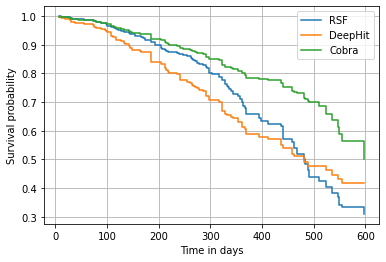

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


plt.step(event_time, rsf_predictions[1], where="post", label=str('RSF'))
plt.step(event_time, deep_hit_predictions[1], where="post", label=str('DeepHit'))
plt.step(event_time, cobra_predictions, where="post", label=str('Cobra'))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [16]:
def cobra_plot(patient_id, epsilon, alpha = 4):
    cobra_predictions = np.zeros(len(event_time)) 
    for time in range(len(event_time)):
        cobra_predictions[time] = agregate(patient_id,time, epsilon,alpha)
    plt.step(event_time, rsf_predictions[patient_id], where="post", label=str('RSF'))
    plt.step(event_time, deep_hit_predictions[patient_id], where="post", label=str('DeepHit'))
    plt.step(event_time, mltr_predictions[patient_id], where="post", label=str('MLTR'))
    plt.step(event_time, cox_time_predictions[patient_id], where="post", label=str('Cox_Time'))
    plt.step(event_time, cobra_predictions, where="post", label=str('Cobra'))
    plt.ylabel("Survival probability")
    plt.xlabel("Time in days")
    plt.legend()
    plt.grid(True)

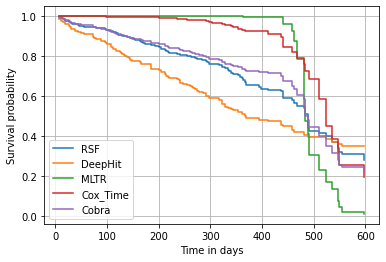

In [17]:
cobra_plot(43, 0.0001, alpha = 4)

In [18]:
# pickle.dump( cobra_predictions, open( "patient_surv_functions/cobra.p", "wb" ) )

In [19]:
cobra_predictions_dictionary = {}

for patient in range(312):
    cobra_predictions = cobra_surv(patient, 0.0001, alpha = 4)
    cobra_predictions_dictionary[patient] = cobra_predictions

In [20]:
cobra_predictions_dictionary[4] - cobra_predictions_dictionary[12] 

array([-0.00711504, -0.00991653, -0.01376887, -0.0170925 , -0.02139313,
       -0.02199563, -0.02487278, -0.02714167, -0.02746384, -0.0287616 ,
       -0.03186545, -0.03332795, -0.03427933, -0.03741349, -0.04048577,
       -0.04667866, -0.04895368, -0.05167952, -0.05563845, -0.0585201 ,
       -0.06122569, -0.06406794, -0.06423873, -0.06752828, -0.07197905,
       -0.07356957, -0.0753388 , -0.07535591, -0.07598328, -0.07913559,
       -0.0810056 , -0.08272671, -0.08529436, -0.08530059, -0.08890026,
       -0.09042056, -0.09473315, -0.09748793, -0.10023062, -0.10027981,
       -0.10029051, -0.1013525 , -0.10453072, -0.10757535, -0.11047503,
       -0.1133715 , -0.11342527, -0.10554306, -0.10565701, -0.10589897,
       -0.106147  , -0.10952413, -0.11153699, -0.11592814, -0.11687525,
       -0.12613398, -0.1287225 , -0.13369353, -0.13954888, -0.14678552,
       -0.14762559, -0.14895439, -0.15872561, -0.16428578, -0.17350244,
       -0.18069887, -0.18149453, -0.18501056, -0.18963436, -0.19

In [21]:
pickle.dump( cobra_predictions_dictionary, open( "patient_surv_functions/cobra.p", "wb" ) )